In [1]:
import os
import shutil
import random


In [3]:
original_dataset_dir = r"C:\fruit classifier\fruits_type\images"
base_dir = r"C:\fruit classifier\fruits_type"


In [5]:
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

In [7]:
for directory in [train_dir, test_dir]:
    if not os.path.exists(directory):
        os.makedirs(directory)


In [9]:
split_ratio = 0.8
for class_name in os.listdir(original_dataset_dir):
    class_path = os.path.join(original_dataset_dir, class_name)
    if os.path.isdir(class_path):
        images = os.listdir(class_path)
        random.shuffle(images)
        split_point = int(len(images) * split_ratio)

        train_class_dir = os.path.join(train_dir, class_name)
        test_class_dir = os.path.join(test_dir, class_name)

        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(test_class_dir, exist_ok=True)

        for img in images[:split_point]:
            shutil.copy(os.path.join(class_path, img), os.path.join(train_class_dir, img))
        for img in images[split_point:]:
            shutil.copy(os.path.join(class_path, img), os.path.join(test_class_dir, img))

print("Dataset split into train and test folders successfully!")


Dataset split into train and test folders successfully!


In [11]:
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
import matplotlib.pyplot as plt
import os


In [13]:
batch_size = 32
epochs = 50
model_name = "fruit_classifier.keras"

path_to_train = r"C:\fruit classifier\fruits_type\train"
path_to_test = r"C:\fruit classifier\fruits_type\test"


In [15]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_data = train_datagen.flow_from_directory(
    path_to_train,
    target_size=(100, 100),
    batch_size=batch_size,
    class_mode='categorical')

test_data = test_datagen.flow_from_directory(
    path_to_test,
    target_size=(100, 100),
    batch_size=batch_size,
    class_mode='categorical')


Found 288 images belonging to 9 classes.
Found 71 images belonging to 9 classes.


In [17]:
num_classes = len(train_data.class_indices)
print(f"Detected classes: {list(train_data.class_indices.keys())}")


Detected classes: ['apple fruit', 'banana fruit', 'cherry fruit', 'chickoo fruit', 'grapes fruit', 'kiwi fruit', 'mango fruit', 'orange fruit', 'strawberry fruit']


In [19]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.summary()


C:\Users\hello\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 33856)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,667,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,689,097 (33.15 MB)

 Trainable params: 8,689,097 (33.15 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy']
)


In [25]:
history = model.fit(
    train_data,
    steps_per_epoch=train_data.samples // batch_size,
    epochs=epochs,
    validation_data=test_data,
    validation_steps=test_data.samples // batch_size
)


Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.8206 - loss: 0.6173 - val_accuracy: 0.5781 - val_loss: 1.5094
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7143 - val_loss: 2.1584
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.7578 - loss: 0.6782 - val_accuracy: 0.5156 - val_loss: 1.6989
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5714 - val_loss: 0.6343
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.8210 - loss: 0.5457 - val_accuracy: 0.5938 - val_loss: 1.4337
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.2857 - val_loss: 2.1648
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.8395 - loss: 0.5514 - val_accuracy: 0.5469 - val_loss: 1.7218
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy

In [27]:
model.save(model_name)
print(f"Model saved as {model_name}")



Model saved as fruit_classifier.keras


In [29]:
plt.figure(figsize=(12, 5))



<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

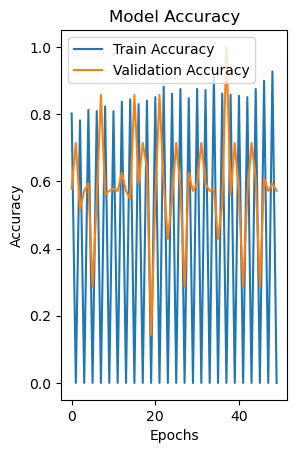

In [31]:
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


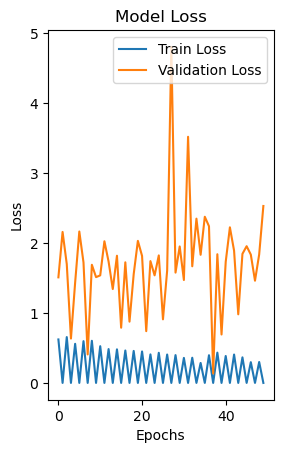

In [33]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show(

In [41]:
test_generator = test_datagen.flow_from_directory(
    r'C:\fruit classifier\fruits_type\test',
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)



Found 71 images belonging to 9 classes.


In [47]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")

# Predictions
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Classification Report
from sklearn.metrics import classification_report
print(classification_report(
    test_generator.classes, 
    y_pred, 
    target_names=test_generator.class_indices.keys()
))


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5731 - loss: 1.9891
Test Accuracy: 0.59
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step
                  precision    recall  f1-score   support

     apple fruit       0.43      0.38      0.40         8
    banana fruit       0.56      0.62      0.59         8
    cherry fruit       0.71      0.62      0.67         8
   chickoo fruit       0.71      0.62      0.67         8
    grapes fruit       0.33      0.25      0.29         8
      kiwi fruit       0.67      0.50      0.57         8
     mango fruit       0.29      0.29      0.29         7
    orange fruit       0.80      1.00      0.89         8
strawberry fruit       0.67      1.00      0.80         8

        accuracy                           0.59        71
       macro avg       0.57      0.59      0.57        71
    weighted avg       0.58      0.59      0.58        71



3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 769ms/step


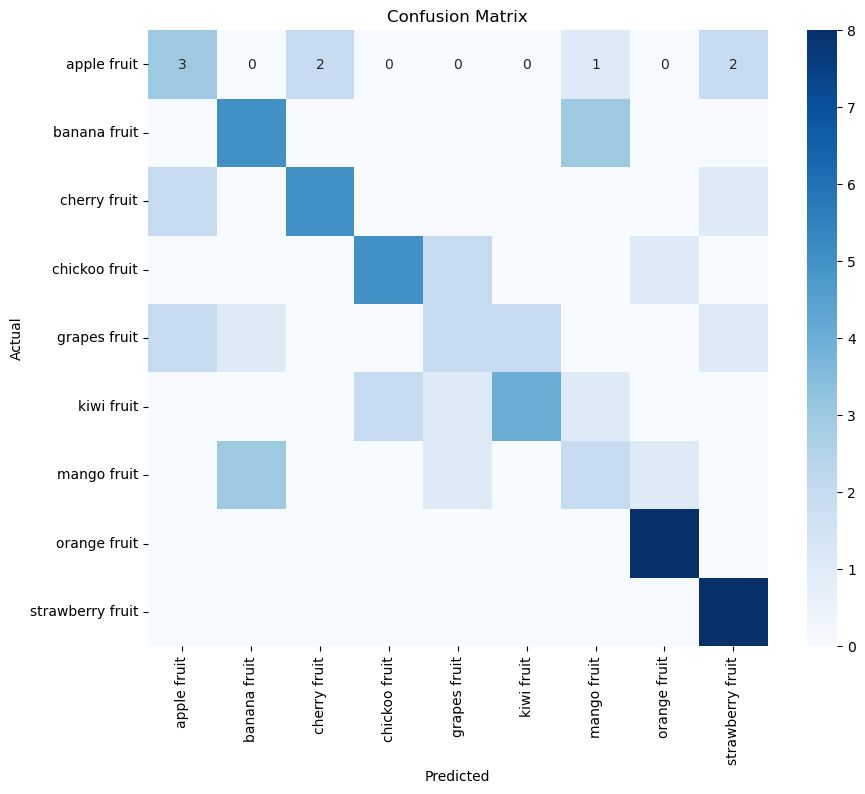

                  precision    recall  f1-score   support

     apple fruit       0.43      0.38      0.40         8
    banana fruit       0.56      0.62      0.59         8
    cherry fruit       0.71      0.62      0.67         8
   chickoo fruit       0.71      0.62      0.67         8
    grapes fruit       0.33      0.25      0.29         8
      kiwi fruit       0.67      0.50      0.57         8
     mango fruit       0.29      0.29      0.29         7
    orange fruit       0.80      1.00      0.89         8
strawberry fruit       0.67      1.00      0.80         8

        accuracy                           0.59        71
       macro avg       0.57      0.59      0.57        71
    weighted avg       0.58      0.59      0.58        71



In [61]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predictions
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Confusion matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig("confusion_matrix.png")
plt.show()

# Classification report
report = classification_report(test_generator.classes, y_pred,
                               target_names=test_generator.class_indices.keys())
with open("classification_report.txt", "w") as f:
    f.write(report)
print(report)


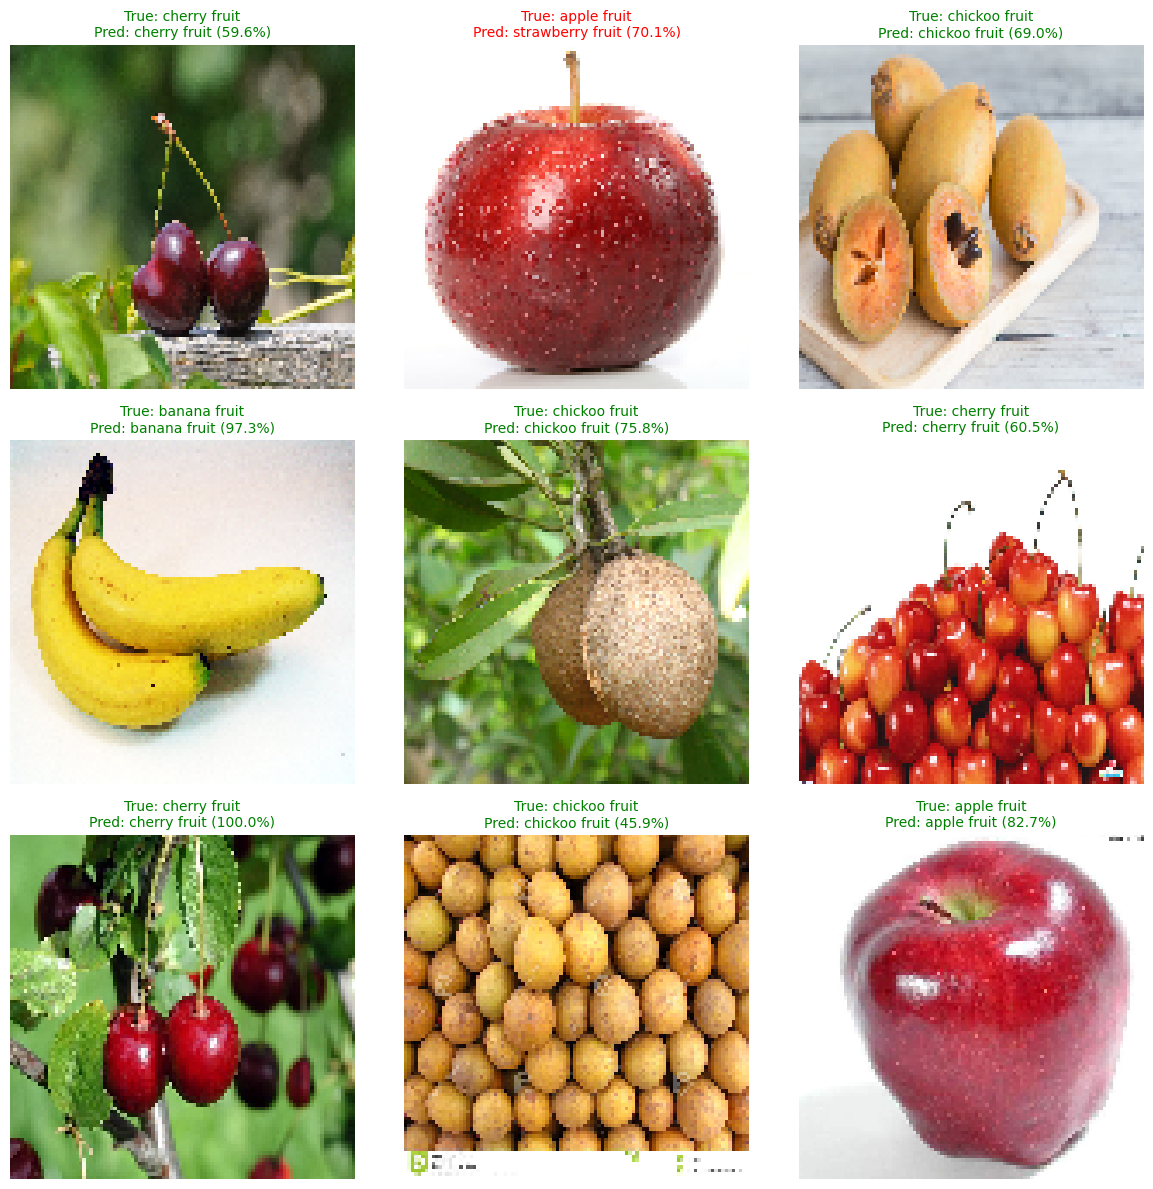

In [127]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Make sure test_generator was created with shuffle=False
labels = list(test_generator.class_indices.keys())

# Get all test data (1 full pass through generator)
images, true_labels = next(test_generator)

# Pick 9 random indices from this batch
indices = random.sample(range(len(images)), 9)

plt.figure(figsize=(12, 12))

for i, idx in enumerate(indices):
    img = images[idx]
    label = true_labels[idx]

    # Predict for single image
    pred = model.predict(np.expand_dims(img, axis=0), verbose=0)
    pred_label_idx = np.argmax(pred)
    true_label_idx = np.argmax(label)

    pred_label = labels[pred_label_idx]
    true_label_name = labels[true_label_idx]
    confidence = pred[0][pred_label_idx] * 100

    # Convert back to [0,255] for better display
    img_display = (img * 255).astype(np.uint8)

    plt.subplot(3, 3, i+1)
    plt.imshow(img_display)

    # Title color: green if correct, red if wrong
    color = "green" if pred_label_idx == true_label_idx else "red"
    plt.title(f"True: {true_label_name}\nPred: {pred_label} ({confidence:.1f}%)", color=color, fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.savefig("Sample_predictions.jpg", dpi=300)
plt.show()


In [133]:
# Save Model Architecture Summary to a text file
summary_file = "model_summary.txt"

with open(summary_file, "w", encoding="utf-8") as f:
    f.write("=== Model Architecture Summary ===\n\n")
    model.summary(print_fn=lambda x: f.write(x + "\n"))

print(f"Model summary saved to {summary_file}")



Model summary saved to model_summary.txt


In [1]:
# Push Jupyter Notebook project to GitHub from inside the notebook

!cd "C:/Users/hello/Fruit-Type-Classifier" && \
 git config --global user.name "CodeByHarini" && \
 git config --global user.email "helloharini08@gmail.com" && \
 git remote add origin https://github.com/CodeByHarini/Fruit-Type-Classifier.git && \
 git add . && \
 git commit -m "Initial commit - Fruit Type Classifier" && \
 git branch -M main && \
 git push -u origin main


fatal: not a git repository (or any of the parent directories): .git
